In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *


from PIL import Image
from numpy import array

# import skimage
import time

# import cv2
import numpy as np

from torchvision.utils import save_image
import torch
import matplotlib

In [3]:
import cv2

In [4]:
def assignFlowToSegs(segs, flow, nchannels):
    """
    Maps a tensor flow of shape (nx, ny, nv)
    using a tensor segs of shape (1, nx, ny)
    with discrete values in the range(nchannels)
    onto a onehot style tensor of shape (nchannels, nv, nx, ny)
    """
    nx, ny, nv = flow.shape
    x,y = np.meshgrid(np.arange(nx), np.arange(ny))
    res = np.zeros((nchannels, nv, nx, ny))
    res[segs.T.ravel(), :, x.ravel(), y.ravel()] = flow[x.ravel(), y.ravel(), :]
    return res

In [5]:
def segs2onehot(frame, nchannels):
    """
    Converts a tensor of shape (1, imgx, imgy)
    with discrete values in the range(nchannels)
    to a onehot style tensor of shape (nchannels, imgx, imgy)
    """
    *_, nx, ny = frame.shape
    x,y = np.meshgrid(np.arange(nx), np.arange(ny))
    res = np.zeros((nchannels, nx, ny))
    res[frame.T.ravel(), x.ravel(), y.ravel()] = 1
    return res

### Import Segmented Image

*** remember you need only ONE channel from segmented image

In [7]:
im = cv2.imread('segImage1.png')

In [8]:
im.shape

(360, 480, 3)

### Separate one channel from im

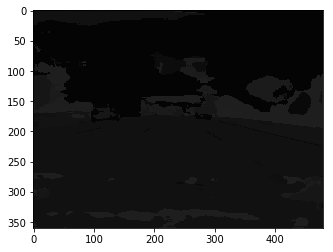

In [9]:
plt.imshow(im)

In [10]:
# Create new image with one channel 
new_im = im[:, : , 2]

In [11]:
new_im.shape

(360, 480)

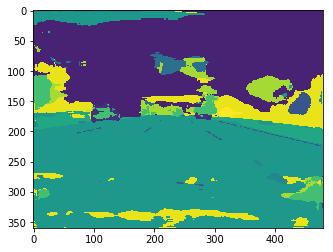

In [12]:
plt.imshow(new_im)

### One-Hot (Torch Version) - Segmented image

In [13]:
torchExFloatTensor = torch.from_numpy(new_im)

In [14]:
torchExFloatTensor.shape

torch.Size([360, 480])

In [15]:
one_hot = torch.nn.functional.one_hot(torchExFloatTensor.to(torch.int64), 32)

In [16]:
type(one_hot)

torch.Tensor

In [17]:
one_hot.shape

torch.Size([360, 480, 32])

### Import optical_flow_image

In [31]:
flow_image = cv2.imread('testImages/optFlow1.png')

In [32]:
flow_image.shape

(360, 480, 3)

### Separate channel - get a single channel from flow_image

In [34]:
new_flow_im = flow_image[:, :, 1]

In [35]:
new_flow_im.shape

(360, 480)

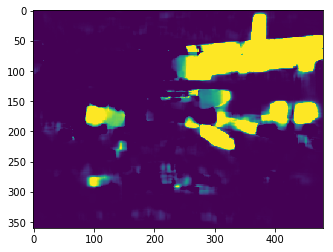

In [36]:
plt.imshow(new_flow_im)

In [37]:
type(new_flow_im)

numpy.ndarray

### Convert new_flow_im to a tensor

In [38]:
flow_image_tensor = torch.from_numpy(new_flow_im)

In [39]:
flow_image_tensor.shape

torch.Size([360, 480])

### One-hot segmented tensor converted into Byte Tensor 

In [40]:
one_hot_byte = one_hot.type(torch.ByteTensor)

In [41]:
type(one_hot_byte)

torch.Tensor

In [42]:
one_hot_byte.shape

torch.Size([360, 480, 32])

### Combine: vector = optical_flow + one_hot_segmented_image

In [43]:
vector = torch.matmul(flow_image_tensor,one_hot_byte)

In [44]:
vector.shape

torch.Size([360, 360, 32])

In [46]:
vector[0][12]

tensor([  0,   0,   0,   0, 136,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   9,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0], dtype=torch.uint8)

In [47]:
type(vector)

torch.Tensor

## Pool vector

## Take cartesian coordinates in vector, then convert to polar coordinates

### Create a datablock with new images and txt file

In [133]:
# path = /home/jupyter.../vectorImages
path = ...

In [136]:
# Labels 

labels_folder_path = ...

In [134]:
tfms = get_transforms(do_flip=False)

In [ ]:
# Fix this
data = (ImageDataBunch.from_folder(path, ds_tfms=tfms, size=64)
       .from_folder(labels_folder_path)
       .split_subsets(train_size=0.7, valid_size=0.3, seed=None))

### GRU Version

In [83]:
class Model5(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Input to Hidden layer
        self.i_h = nn.Embedding(nv,nh)
        
        # RNN 
        self.rnn = nn.GRU(nh, nh, 2, batch_first=True)
        
        # Hidden layer to output
        self.h_o = nn.Linear(nh,nv)
        
        # Batchnore 1D-flat 
        self.bn = BatchNorm1dFlat(nh)
        
        # Hidden layer 
        self.h = torch.zeros(2, bs, nh).cuda()
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(self.bn(res))

In [ ]:
learn = Learner(data, Model5(), metrics=accuracy)